In [70]:
import os
import sys
import cv2
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)

In [71]:
def loadImages(dir):
    filenames = os.listdir(dir)
    sorted_filenames = sorted(filenames, key=lambda x: int(x.split('.')[0]))

    images = []
    for filename in sorted_filenames:
        img = cv2.imread(os.path.join(dir,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
            print(filename)
    return images

In [72]:
images = loadImages("../../test/dataset")

0.jpg
1.jpg
2.jpg
3.jpg
4.jpg
5.jpg
6.jpg
7.jpg
8.jpg
9.jpg
10.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg
17.jpg
18.jpg
19.jpg
20.jpg
21.jpg
22.jpg
23.jpg
24.jpg
25.jpg
26.jpg
27.jpg
28.jpg
29.jpg
30.jpg
31.jpg
32.jpg
33.jpg
34.jpg
35.jpg
36.jpg
37.jpg
38.jpg
39.jpg
40.jpg
41.jpg
42.jpg
43.jpg
44.jpg
45.jpg
46.jpg
47.jpg
48.jpg
49.jpg
50.jpg
51.jpg
52.jpg
53.jpg
54.jpg
55.jpg
56.jpg
57.jpg
58.jpg
59.jpg
60.jpg
61.jpg
62.jpg
63.jpg
64.jpg
65.jpg
66.jpg
67.jpg
68.jpg
69.jpg
70.jpg
71.jpg
72.jpg
73.jpg
74.jpg
75.jpg
76.jpg
77.jpg
78.jpg
79.jpg
80.jpg
81.jpg
82.jpg
83.jpg
84.jpg
85.jpg
86.jpg
87.jpg
88.jpg
89.jpg
90.jpg
91.jpg
92.jpg
93.jpg
94.jpg
95.jpg
96.jpg
97.jpg
98.jpg
99.jpg
100.jpg
101.jpg
102.jpg
103.jpg
104.jpg
105.jpg
106.jpg
107.jpg
108.jpg
109.jpg
110.jpg
111.jpg
112.jpg
113.jpg
114.jpg
115.jpg
116.jpg
117.jpg
118.jpg
119.jpg
120.jpg
121.jpg
122.jpg
123.jpg
124.jpg
125.jpg
126.jpg
127.jpg
128.jpg
129.jpg
130.jpg
131.jpg
132.jpg
133.jpg
134.jpg
135.jpg
136.jpg
137.jpg
138.jp

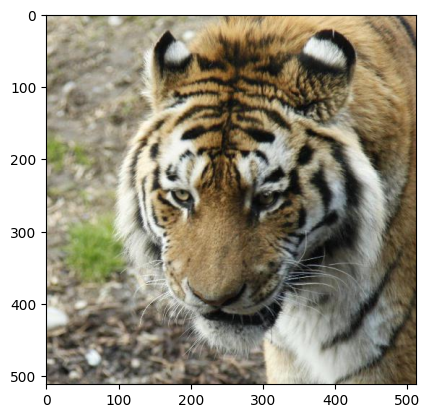

In [73]:
plt.imshow(images[0])

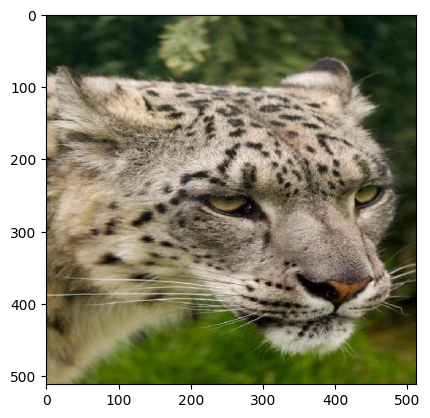

In [74]:
plt.imshow(images[1])

In [75]:
def rgb_to_hsv(img):
    img = img / 255.0

    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    cmax = np.max(img, axis=2); cmin = np.min(img, axis=2)
    delta = cmax - cmin
    h = np.zeros_like(cmax); s = np.zeros_like(cmax)
    v = cmax

    with np.errstate(invalid='ignore'):
        h[(delta != 0) & (cmax == r)] = 60 * (((g - b) / delta) % 6)[((delta != 0) & (cmax == r))]
        h[(delta != 0) & (cmax == g)] = 60 * ((b - r) / delta + 2)[((delta != 0) & (cmax == g))]
        h[(delta != 0) & (cmax == b)] = 60 * ((r - g) / delta + 4)[((delta != 0) & (cmax == b))]

    s[cmax != 0] = delta[cmax != 0] / cmax[cmax != 0]

    return np.dstack((h, s, v))

In [76]:
def hsv_quantify(img):
    h, s, v = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    def map_h(h):
        if h <= 25:
            return 1
        elif h <= 40:
            return 2
        elif h <= 120:
            return 3
        elif h <= 190:
            return 4
        elif h <= 270:
            return 5
        elif h <= 295:
            return 6
        elif h <= 315:
            return 7
        else:
            return 0

    def map_sv(value):
        if value < 0.2:
            return 0
        elif value < 0.7:
            return 1
        else:
            return 2

    mapped_h = np.vectorize(map_h)(h)
    mapped_s = np.vectorize(map_sv)(s)
    mapped_v = np.vectorize(map_sv)(v)

    return np.dstack((mapped_h, mapped_s, mapped_v))

In [77]:
def split_image(img):
    block_size = ((img.shape[0]) // 4)

    num_blocks_x = img.shape[0] // block_size
    num_blocks_y = img.shape[1] // block_size

    blocks = []

    for i in range(num_blocks_x):
        for j in range(num_blocks_y):
            block = img[i * block_size: (i + 1) * block_size, j * block_size: (j + 1) * block_size, :]
            blocks.append(block)

    return np.array(blocks)

In [78]:
def build_vector(img):
    num_h_levels = 8
    num_sv_levels = 3

    block_frequency_vectors = []

    for block in img:
        flattened_block = block.reshape((-1, 3))

        block_frequency_vector = np.zeros((num_h_levels * num_sv_levels * num_sv_levels,), dtype=int)

        for pixel in flattened_block:
            h_index = int(pixel[0])
            s_index = int(pixel[1])
            v_index = int(pixel[2])

            index = h_index * (num_sv_levels * num_sv_levels) + s_index * num_sv_levels + v_index
            block_frequency_vector[index] += 1

        block_frequency_vectors.append(block_frequency_vector)

    block_frequency_vectors_array = np.array(block_frequency_vectors)
    return block_frequency_vectors_array


In [79]:
for i in range(500):
    images[i] = build_vector(split_image(hsv_quantify(rgb_to_hsv(images[i]))))
    # images[i] = hsv_quantify(images[i])
    # images[i] = split_image(images[i])
    # images[i] = build_vector(images[i])

In [80]:
def cosine_similarity(A, B):
    A = A.astype(np.int64)
    B = B.astype(np.int64)
    cosine = 0

    for i in range(A.shape[0]):
        if (i == 5 or i == 6 or i == 9 or i == 10):
            cosine += (2*(np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i]))))
        else:
            cosine += (np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i])))

        # cosine += (np.dot(A[i],B[i]) / (norm(A[i])*norm(B[i])))

    percent = ((1 + (cosine / 20))/2) * 100
    print(percent)

In [94]:
cosine_similarity(images[9], images[9])

100.0
